# Выбор локации для скважины

**_Условия задания_**

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Импорт данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats as st
from sklearn.preprocessing import StandardScaler

In [2]:
df_0 = pd.read_csv('/datasets/geo_data_0.csv')
df_0.name = 'region_1'

df_1 = pd.read_csv('/datasets/geo_data_1.csv')
df_1.name = 'region_2'

df_2 = pd.read_csv('/datasets/geo_data_2.csv')
df_2.name = 'region_3'

In [3]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


**Признаки:**
* `id` - идентификатор скважины
* `f0`, `f1`, `f2` - признаки месторождений
* `product` - объём запасов в скважине (тыс. баррелей) - **_целевой признак для задачи регрессии_**

### Предобработка

Мы располагаем данными о трех регионах, в каждом 10000 месторождений. Пропущенных значений нет, но проверим данные на дубликаты. Далее посмотрим, как распределяется наш целевой признак в трех регионах. 

In [4]:
print(df_0.duplicated().value_counts())
print(df_1.duplicated().value_counts())
print(df_2.duplicated().value_counts())

False    100000
dtype: int64
False    100000
dtype: int64
False    100000
dtype: int64


### Первичный анализ

Дубликатов нет ни в одной базе данных. Изучим сначала признаки `f0`, `f1`, и `f2`, а потом и целевой признак. 

#### Признаки  `f0`, `f1`, и `f2`

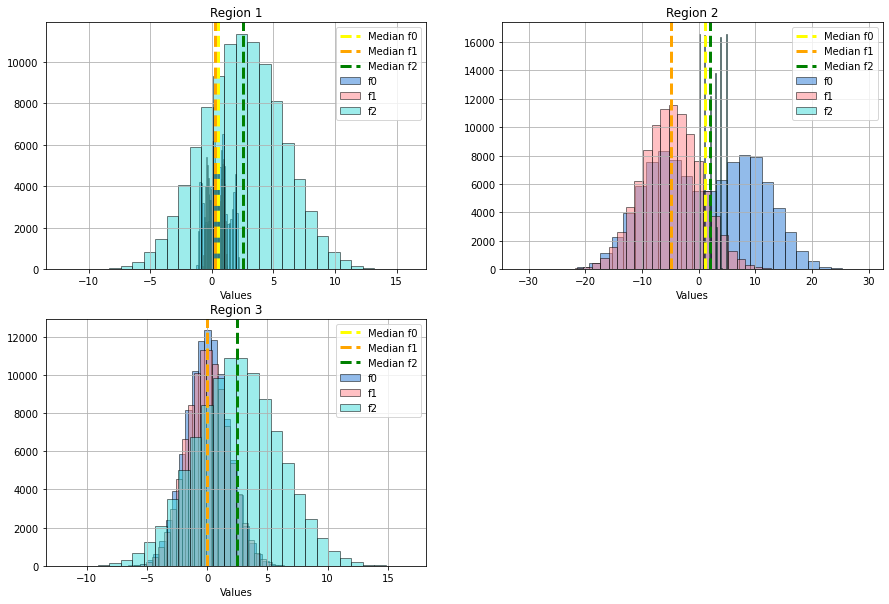

In [5]:
fig=plt.figure()

ax_1=fig.add_subplot(2, 2, 1)
plt.hist(df_0['f0'], bins=30, alpha=0.5, edgecolor='black', color='#2678D7')
plt.hist(df_0['f1'], bins=30, alpha=0.5, edgecolor='black', color='#ff8389')
plt.hist(df_0['f2'], bins=30, alpha=0.5, edgecolor='black', color='#3ddbd9')
plt.axvline(x=df_0['f0'].median(),linewidth=3, color='yellow', linestyle='--')
plt.axvline(x=df_0['f1'].median(),linewidth=3, color='orange', linestyle='--')
plt.axvline(x=df_0['f2'].median(),linewidth=3, color='green', linestyle='--')
plt.grid()
plt.xlabel('Values')
plt.legend(['Median f0', 'Median f1', 'Median f2','f0', 'f1', 'f2'])
plt.title('Region 1')

ax_2=fig.add_subplot(2, 2, 2)
plt.hist(df_1['f0'], bins=30, alpha=0.5, edgecolor='black', color='#2678D7')
plt.hist(df_1['f1'], bins=30, alpha=0.5, edgecolor='black', color='#ff8389')
plt.hist(df_1['f2'], bins=30, alpha=0.5, edgecolor='black', color='#3ddbd9')
plt.axvline(x=df_1['f0'].median(),linewidth=3, color='yellow', linestyle='--')
plt.axvline(x=df_1['f1'].median(),linewidth=3, color='orange', linestyle='--')
plt.axvline(x=df_1['f2'].median(),linewidth=3, color='green', linestyle='--')
plt.grid()
plt.xlabel('Values')
plt.legend(['Median f0', 'Median f1', 'Median f2','f0', 'f1', 'f2'])
plt.title('Region 2')

ax_3=fig.add_subplot(2, 2, 3)
plt.hist(df_2['f0'], bins=30, alpha=0.5, edgecolor='black', color='#2678D7')
plt.hist(df_2['f1'], bins=30, alpha=0.5, edgecolor='black', color='#ff8389')
plt.hist(df_2['f2'], bins=30, alpha=0.5, edgecolor='black', color='#3ddbd9')
plt.axvline(x=df_2['f0'].median(),linewidth=3, color='yellow', linestyle='--')
plt.axvline(x=df_2['f1'].median(),linewidth=3, color='orange', linestyle='--')
plt.axvline(x=df_2['f2'].median(),linewidth=3, color='green', linestyle='--')
plt.grid()
plt.xlabel('Values')
plt.legend(['Median f0', 'Median f1', 'Median f2','f0', 'f1', 'f2'])
plt.title('Region 3')


plt.gcf().set_size_inches(15, 10)
plt.show()

In [6]:
print ('Region 1')
df_0.describe()

Region 1


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [7]:
print ('Region 2')
df_1.describe()

Region 2


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [8]:
print ('Region 3')
df_2.describe()

Region 3


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Мы видим, что признаки внутри каждого региона распределены неравномерно: у них разные показатели среднего и медианы. Можно отметить, что `f1` по всем регионам имеет наименьшие значения средного и медианы. В регионах 1 и 3 признак `f2` распределен похожим образом с близкими значениями минимума, максимума, среднего, медианы и стандартного отклонения. Это наглядно показано на гистограммах. Остальные же признаки в регионах 1 и 3 ведут себя по-разному. 

Регион 2 же не имеет общих характеристик с другими регионами: здесь очень большой разброс данных у признаков `f0` и `f1`, в то время как признак `f2` представляет собой несколько групп данных в пределах значений -0.02 и 5. 

#### Целевой признак `product`

In [9]:
product_dict = {'df_0': df_0['product'], 
                'df_1': df_1['product'],
                'df_2': df_2['product']
               }
product = pd.DataFrame(product_dict)

In [10]:
product.describe()

,df_0,df_1,df_2
count,100000.000000,100000.000000,100000.000000
mean,92.500000,68.825000,95.000000
std,44.288691,45.944423,44.749921
min,0.000000,0.000000,0.000000
25%,56.497507,26.953261,59.450441
50%,91.849972,57.085625,94.925613
75%,128.564089,107.813044,130.595027
max,185.364347,137.945408,190.029838


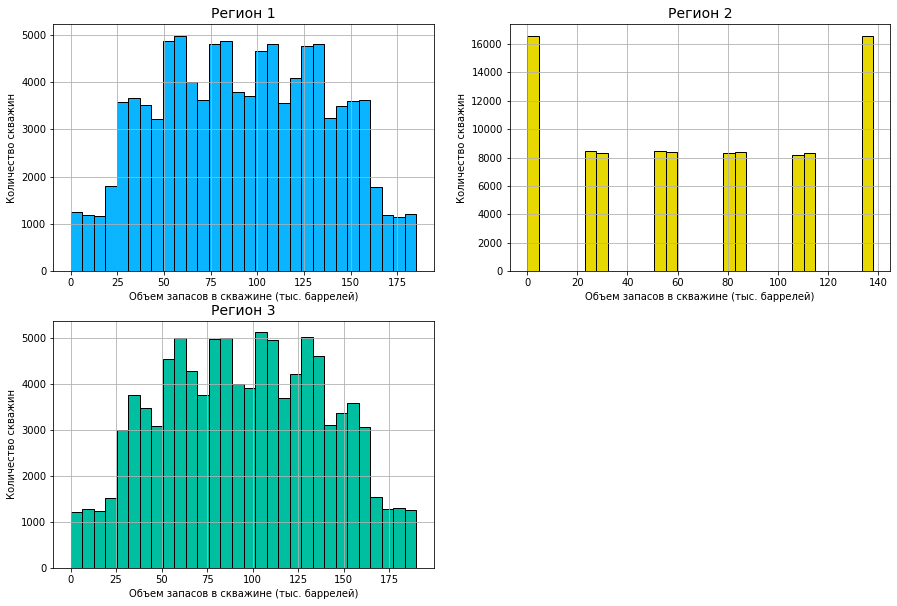

In [11]:
fig=plt.figure()

ax_1=fig.add_subplot(2, 2, 1)
plt.title('Регион 1', fontsize=14)
plt.ylabel('Количество скважин')
plt.xlabel('Объем запасов в скважине (тыс. баррелей)')
product['df_0'].hist(bins=30, figsize=(10, 5), color='#0bb4ff', ec='black')

ax_2=fig.add_subplot(2, 2, 2)
product['df_1'].hist(bins=30, figsize=(10, 5), color='#e6d800', ec='black')
plt.title('Регион 2', fontsize=14)
plt.ylabel('Количество скважин')
plt.xlabel('Объем запасов в скважине (тыс. баррелей)')

ax_3=fig.add_subplot(2, 2, 3)
product['df_2'].hist(bins=30, figsize=(10, 5), color='#00bfa0', ec='black')
plt.title('Регион 3', fontsize=14)
plt.ylabel('Количество скважин')
plt.xlabel('Объем запасов в скважине (тыс. баррелей)')

plt.gcf().set_size_inches(15, 10)
plt.show()

Также рассмотрим признаки, о которых нам мало чего известно и их корреляцию между собой и с признаком `product`.

In [12]:
(df_0[['f0', 'f1', 'f2', 'product']]).corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [13]:
(df_1[['f0', 'f1', 'f2', 'product']]).corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [14]:
(df_2[['f0', 'f1', 'f2', 'product']]).corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


Можно заметить, что в регионах 1 и 3 распределение данных стремится к "куполу" и данные в принципе распределены похожим образом: среднее и медиана близки, хоть и в регионе 3 характеристики немного выше (среднее 92.5 vs 95, медиана 91.8 vs 95). Также можно наблюдать очень слабую положительную корреляцию между признаком `f2` и целевым признаком `product` (0.48 в регионе 1 и 0.44 в регионе 3).

Что же касается региона 2, здесь данные совсем не похожи на другие регионы. Во-первых, о "куполе" здесь речи не идет: мы четко наблюдаем 6 групп, куда попадают скажины со схожим количеством баррелей нефти в каждой группе. Также можно заметить очень странную связь, а именно очень сильную положительную корреляцию между `f2` и целевым признаком: 0.99. Можно сказать, что в этом регионе при увеличении признака `f2` в абсолютном большинстве случаев нарастает и количество баррелей в месторождении. И распределения целевого признака и признака `f2` в этом регионе в целом похожи по своей структуре, ведь признак `f2` тоже представляет собой несколько групп данных. 

Мы понимаем, что данные у нас синтетические, поэтому мы с ними ничего делать не будем, но и не будем удивляться, если модель будет радостно и точно предсказывать целевой признак в этом регионе. 

### Промежуточные выводы

Мы рассмотрели три базы данных - **`df_0`, `df_1` и `df_2`** - каждая из которых содержит данные о месторождениях нефти в отдельном регионе.

**Данные регионов 1 и 3 имеют некоторое сходство по распределению целевого признака`product`**, т.е. количества баррелей нефти в месторождении - наблюдется "купол". Также в этих двух регионах наблюдается некоторое сходство в распределении признака `f2`. Это характеристика месторождения, фактической информацией и которой мы не располагаем, однако наверняка известно, что значения таких характеристик имеют значение для моделирования. На этом сходства между регионами 1 и 3 заканчиваются.

**Регион 2 стоит особняком: здесь мы наблюдаем очень большой разброс данных признаков** `f0` **и** `f1`**, а признак** `f2` **выглядит несколько странно на общем фоне**, так как представляет собой несколько групп данных в пределах значений -0.02 и 5. Похожим образом распределяется и целевой признак в этом регионе: мы четко видим 6 групп данных и никакого "купола". К тому же, **обнаруживается очень сильная положительная корреляция между признаком** `f2` **и целевым признаком** `product` **именно в этом регионе.**

Можно предположить, что модели будет особенно легко предсказывать целевой признак именно в регионе 2 за счет такой корреляции и мы увидим крайне низкое значение метрики RMSE.

## Обучение и проверка модели

Задача - предсказать количество нефти в месторождении, а значит речь идет о модели регрессии. Мы будем пользоваться линейной регрессией и измерять результаты по среднему запасу предсказанного сырья и RMSE модели. 

Поскольку значения признаков распределены неравномерно и имеются в том числе отрицательные значения, мы проведем масштабирование данных. Так мы облегчим процесс обучения модели и поможем ей лучше предсказывать целевой признак. 

Но сначала подготовим необходимые функции, чтобы упростить работу. 

### Функции

#### Функция для разделения данных на обучающую и валидационную выборки + стандартизация данных через _ScandardScaler_

In [15]:
pd.options.mode.chained_assignment = None


def split_data(data):
    
    target = data['product']
    features = data.drop(['product', 'id'], axis=1)
   
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=12345)

    scaler = StandardScaler()
    numeric = ['f0', 'f1', 'f2']
    scaler.fit(features_train[numeric])
    
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    
    return features_train, features_valid, target_train, target_valid

#### Функция для обучения модели, получения предсказаний и рассчета показателей

In [16]:
def train_and_predict (model, features_train, features_valid, target_train, target_valid):
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    rsme = mean_squared_error(target_valid, predicted_valid) ** 0.5
    mean_crude = target_valid.mean()
    mean_predicted_crude = predicted_valid.mean()
    
    return rsme, mean_crude, mean_predicted_crude, predicted_valid

### Обучение модели и расчет показателей

In [17]:
model = LinearRegression()

rsme_list = []
mean_crude_list = []
mean_predicted_crude_list = []

df_0_product = []
df_1_product = []
df_2_product = []

df_0_predicted = []
df_1_predicted = []
df_2_predicted = []

for data in [df_0, df_1, df_2]:
    features_train, features_valid, target_train, target_valid = split_data(data)
    rsme, mean_crude, mean_predicted_crude, predicted_valid = train_and_predict(
        model, features_train, features_valid, target_train, target_valid)
    
    rsme_list.append(rsme)
    mean_crude_list.append(mean_crude)
    mean_predicted_crude_list.append(mean_predicted_crude)
    
    if data.name == 'region_1':
        df_0_predicted = predicted_valid
        df_0_product = target_valid
        df_0_oil = pd.DataFrame(list(zip(df_0_product, df_0_predicted)), columns = ['product', 'predicted'])
        df_0_oil.name = 'region_1'
        
    elif data.name == 'region_2': 
        df_1_predicted = predicted_valid
        df_1_product = target_valid
        df_1_oil = pd.DataFrame(list(zip(df_1_product, df_1_predicted)), columns = ['product', 'predicted'])
        df_1_oil.name = 'region_2'
            
    else:
        df_2_predicted = predicted_valid
        df_2_product = target_valid
        df_2_oil = pd.DataFrame(list(zip(df_2_product, df_2_predicted)), columns = ['product', 'predicted'])
        df_2_oil.name = 'region_3'
            
index = ['rmse', 'mean_crude', 'mean_predicted_crude']
columns = ['region_1','region_2','region_3']
model_results = pd.DataFrame(
    data = [rsme_list, mean_crude_list, mean_predicted_crude_list], 
    columns = columns, 
    index = index).T.round(4)

In [18]:
model_results

,rmse,mean_crude,mean_predicted_crude
region_1,37.5794,92.0786,92.5926
region_2,0.8931,68.7231,68.7285
region_3,40.0297,94.8842,94.9650


### Промежуточные выводы

In [19]:
print ('Всего сырья в регионе 1, млрд. баррелей:', (df_0['product'].sum() / 10**6).round(2))
print ('Всего сырья в регионе 2, млрд. баррелей:', (df_1['product'].sum() / 10**6).round(2))
print ('Всего сырья в регионе 3, млрд. баррелей:', (df_2['product'].sum() / 10**6).round(2))

Всего сырья в регионе 1, млрд. баррелей: 9.25
Всего сырья в регионе 2, млрд. баррелей: 6.88
Всего сырья в регионе 3, млрд. баррелей: 9.5


На этом этапе мы разделили выборки на обучающие и валидационные, обучили модель и построили предсказания. Затем рассчитали средний реальный запас сырья, средний запас предсказанного сырья и RMSE.

**По среднему запасу сырья на первом месте регион 3, за ним идет регион 1 и на последнем месте регион 2.**

**В регионе 2 самые небольшие средние запасы на месторождение: 68.7 тыс. баррелей. Как мы и предполагали, значение метрики RMSE в регионе 2 рекордно маленькое: всего 0.893.** Модель здесь практически не ошибается и предсказанный средний объем сырья отличается от реального всего на 5 баррелей. Это немудрено: в этом регионе данные довольно странные, а корреляция признака** `f2` и целевого признака `product` очень высока.

Что же касается регионов 1 и 3, здесь картина более похожа на реальную. **В регионе 1 средний запас сырья 92.0786 тыс. баррелей, а модель предсказывает чуть больше, 92.5926 тыс. RMSE модели здесь составляет 37.5794** - то есть на это количество тыс. баррелей по всей базе данных модель ошиблась.

**В регионе 3 средний запас сырья составляет 94.8842 тыс. баррелей, а модель предсказала 94.965 тыс. RMSE модели здесь 94.8842.**

Можно предположить, что на фоне суммарного количества сырья в регионах 1 и 3 (9.25 и 9.5 млрд. баррелей) показатели ошибки RMSE (37.5794 и 94.965 тыс. баррелей) не кажутся очень катастрофическими.

## Подготовка к расчёту прибыли

Для начала объявим переменные, в которых будем указывать ключевые значения для наших рассчетов. Затем рассчитаем достаточный объём сырья для безубыточной разработки новой скважины и сравним его со средним запасом в каждом регионе.

### Объявление переменных

* `BUDGET` - бюджет на разработку скважин в регионе
* `OIL_FIELDS_EXAMINED` - количество точек, которые исследуют в регионе
* `OIL_FIELDS_BEST` - лучшие точки для разработки
* `BARREL_K_COST` - стоимость 1000 баррелей в рублях
* `LOSS_PROB` - максимально допустимая вероятность убытков

In [20]:
BUDGET = 10*10**9
OIL_FIELDS_EXAMINED = 500
OIL_FIELDS_BEST = 200 
BARREL_K_COST = 450*10**3
LOSS_PROB = 0.025

### Достаточный объем сырья для скважины

Достаточный объем сырья - это такой объем, при котором суммарный объем полученного сырья из финальных скважин будет равен бюджету на разработку этих скважин. Поделив этот объем на количество скважин, отобранных для разработку, мы получим достаточный объем сырья для одной скважины. 

In [21]:
min_product = round(BUDGET / (OIL_FIELDS_BEST * BARREL_K_COST), 1)

In [22]:
print ('Достаточный объем сырья для скважины, тыс. баррелей:', min_product)
print ()
print ('Средний объем сырья в скважине в регионах, тыс. баррелей:')
print ('Регион 1:', df_0['product'].mean().round(2))
print ('Регион 2:', df_1['product'].mean().round(2))
print ('Регион 3:', df_2['product'].mean().round(2))

Достаточный объем сырья для скважины, тыс. баррелей: 111.1

Средний объем сырья в скважине в регионах, тыс. баррелей:
Регион 1: 92.5
Регион 2: 68.83
Регион 3: 95.0


### Промежуточные выводы

Мы объявили переменные со значениями, которые нам необходимы для расчеты прибыли и рисков, а также рассчитали, что **достаточный объем сырья для скважины** при данных значениях переменных **составляет 111.1 тыс. баррелей нефти.**

Мы видим, что просто "средних" скважин нам недостаточно! Даже в самом богатом регионе 3 месторождение в среднем имеет 95 тыс. баррелей нефти, что на 16.1 тыс. меньше нижней границы.*

## Расчёт прибыли и рисков 

На этом этапе мы рассчитаем прибыть компании и оценим риски для каждого региона, а также определим, какой регион будет оптимальным для разработки скважин. 

Сначала мы напишем функцию, которая отберет скважины с наибольшими предсказанными запасами сырья и рассчитает прибыль. Затем мы проведем эти рассчеты для каждого региона

### Функция для рассчета прибыли

На предыдущем этапе были созданы 3 базы данных, в которые входит только 2 переменные: `product` (значение **target_valid**) и `predicted` (значение **predicted_valid**). На каждый регион по базе. 

Функция принимает базу данных (одну из этих трех) и параметр **n** - количество лучших месторождений, которое нас интересует. И на выходе выдает прибыль в млн. рублей. 

In [23]:
def profit(target, probabilities, n):
    probs_sorted = probabilities.sort_values(ascending=False)
    top_fields = target[probs_sorted.index][:n]
    profit = round(((top_fields.sum() * BARREL_K_COST - BUDGET) / 10**6), 2)
    
    return profit

### Рассчет прибыли для топ-500 и топ-200 месторождений

In [24]:
top_profit = pd.DataFrame(
    index=['region_1', 'region_2', 'region_3'], 
    columns=['top_500', 'top_200'], 
    data=[[profit(df_0_oil['product'], df_0_oil['predicted'], OIL_FIELDS_EXAMINED), 
           profit(df_0_oil['product'], df_0_oil['predicted'], OIL_FIELDS_BEST)],
         [profit(df_1_oil['product'], df_1_oil['predicted'], OIL_FIELDS_EXAMINED), 
           profit(df_1_oil['product'], df_1_oil['predicted'], OIL_FIELDS_BEST)],
         [profit(df_2_oil['product'], df_2_oil['predicted'], OIL_FIELDS_EXAMINED), 
           profit(df_2_oil['product'], df_2_oil['predicted'], OIL_FIELDS_BEST)]])

In [25]:
top_profit

,top_500,top_200
region_1,22287.53,3320.83
region_2,21036.29,2415.09
region_3,21108.19,2710.35


Мы видим, что наиболее прибыльным, глядя только на эти цифры, кажется регион 1, за ним следует регион 3 и на последнем месте регион 2. При этом, мы помним, что регион 2 в принципе располагает меньшими объемами сырья, но именно в этом регионе модель предсказывает объемы сырья с самой высокой точностью ввиду высокой корелляции между одним из признаков и целевым признаком. 

### Расчет рисков и прибыли для каждого региона

Мы применим технику _Bootstrap_ для 1000 выборок и найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков по каждому региону. 

Сначала объявим функцию, которая будет принимать на вход данные, количество исследуемых точек, количество лучших отобранных точек и размер выборки. А затем соберем все результаты в таблицу для наглядности. 

#### Функция _bootstrap_

In [26]:
def bootstrap(data, OIL_FIELDS_EXAMINED, OIL_FIELDS_BEST, sample_n):
    state = np.random.RandomState(12345)
    values = []
    
    for i in range(sample_n):
        target_subsample = data['product'].sample(n=OIL_FIELDS_EXAMINED, replace=True, random_state=state)
        probs_subsample = data['predicted'][target_subsample.index] 
        value = profit(target_subsample, probs_subsample, OIL_FIELDS_BEST) 
        values.append(value)
        
    values = pd.Series(values)

    lower = values.quantile(0.025).round(2)
    upper = values.quantile(0.975).round(2)
    mean = values.mean().round(2)
    risk = ((values < 0).mean()*100).round(2)
    
    return lower, upper, mean, risk

#### Результаты функции

In [27]:
lower_list = []
upper_list = []
mean_list = []
risk_list = []

for region in [df_0_oil, df_1_oil, df_2_oil]:
    lower, upper, mean, risk = bootstrap(region, OIL_FIELDS_EXAMINED, OIL_FIELDS_BEST, 1000)
    
    lower_list.append(lower)
    upper_list.append(upper)
    mean_list.append(mean)
    risk_list.append(risk)
    
index = ['lower', 'upper', 'mean_profit', 'risk_prob']
columns = ['region_1','region_2','region_3']
profit_results = pd.DataFrame(
    data = [lower_list, upper_list, mean_list, risk_list], 
    columns = columns, 
    index = index).T.round(4)

In [28]:
profit_results

,lower,upper,mean_profit,risk_prob
region_1,-102.09,947.98,425.94,6.0
region_2,68.87,931.55,515.22,1.0
region_3,-128.88,969.71,435.01,6.4


Добавим полученную таблицу к таблице **`model_results`**, которая описывает работу модели линейной регресии для каждого из трех регионов, и сделаем итоговую таблицу немного симатичней. 

In [29]:
total_results = model_results.round(4).join(profit_results)

total_results.style.format(
    {('rmse'): "{:.2f}",
    ('mean_crude'): "{:.2f}k barrels",
    ('mean_predicted_crude'): "{:.2f}k barrels",
    ('mean_crude'): "{:.2f}k barrels",
    ('lower'): "RUR {:.2f} mln",
    ('upper'): "RUR {:.2f} mln",
    ('mean_profit'): "RUR {:.2f} mln",
    ('risk_prob'): "{:.1f}%",}
    ).set_properties(**{'text-align': 'center'}
    ).highlight_max(color='yellowgreen', subset=[
    'mean_crude', 'mean_predicted_crude','lower', 'upper', 'mean_profit']
    ).highlight_max(color='coral', subset=['rmse', 'risk_prob']
    ).highlight_min(color='yellowgreen', subset=['rmse', 'risk_prob']
    ).highlight_min(color='coral',  subset=[
    'mean_crude', 'mean_predicted_crude','lower', 'upper', 'mean_profit'])


,rmse,mean_crude,mean_predicted_crude,lower,upper,mean_profit,risk_prob
region_1,37.58,92.08k barrels,92.59k barrels,RUR -102.09 mln,RUR 947.98 mln,RUR 425.94 mln,6.0%
region_2,0.89,68.72k barrels,68.73k barrels,RUR 68.87 mln,RUR 931.55 mln,RUR 515.22 mln,1.0%
region_3,40.03,94.88k barrels,94.97k barrels,RUR -128.88 mln,RUR 969.71 mln,RUR 435.01 mln,6.4%


По условию нашего задания вероятность убытков в регионе должна быть меньше 2.5%. 

Так единственным подходящим регионом остается регион 2: в двух остальных регионах, несмотря на большие запасы сырья, вероятность убытков более 6%. 

### Промежуточные выводы

На этом этапе мы объявили функцию, подсчитывающую прибыль компании при разработке n месторождений. Затем техникой _Bootstrap_ мы на 1000 выборок бы рассчитали среднуюю прибыль, 95%-ный доверительный интервал и вероятность рисков для каждого региона при том, что для региона сначала исследуется 500 точек и из них отбирается 200 лучших.

Полученные данные мы оформили в табличку и проанализировали. Так по условию задачи в итоге **подходящим регионом остается только регион 2 с 1% вероятностью убытков.** Тем не менее, даже не такие богатые запасы сырья в регионе 2 в целом предполагают, что **с веротятностью 95% средняя прибыль для топ-200 наилучших скважин из изученных 500 будет располагаться в интервале от 68.87 до 931.55 млн. рублей. Средняя прибыль в этом регионе составляет 515.22 млн.**

Однако, не стоит забывать, что база данных о регионе 2 выглядит странно. **_Для того, чтобы делать финальную рекомендацию, необходимо уточнить, все ли в порядке с данными для этого региона, собирались и объединялись в таблицы ли они отличными от двух других регионов техниками/людьми._** Не стоит отрицать вероятность того, что при измерении показателя `f2` - того самого, у которого корреляция с целевым признаком очень близка к единице - произошла какая-то ошибка.

## Общие выводы

В этом проекте перед нами стояла задача выбрать регион, в котором нефтедобывающая компания сможет максимально прибыльно бурить новые скажины. Мы располагали данными для трех регионов, в каждом регионе 100 тысяч месторождений. Каждое месторождение имеет уникальный id, три характеристики и целевой признак - объем сырья.

Мы провели предобработку данных и обнаружили, что данные в регионе 2 распределены и ведут себя не так, как в двух остальных регионах. Более того, **коэффициент корреляции между одним из признаков** (`f2`) **и целевым признаком очень близок к единице.** 

В рамках проекта мы построили **модель линейной регрессии**, способную предсказывать целевой признак: обучили ее на тренировочной выборке и проверили на валидационной (25% от всех данных). Затем **рассчитали средний реальный запас сырья, средний запас предсказанного сырья и RMSE**. Обнаружили следующее:**
* по среднему запасу сырья на первом месте регион 3 (94.9 тыс баррелей), за ним идет регион 1 (92.1 тыс баррелей) и на последнем месте регион 2 (68.7 тыс баррелей)
* значение метрики RMSE в регионе 2 рекордно маленькое: всего 0.893 - это можно объяснить высокой корреляцией одного из признаков с целевым
* RMSE модели в регионах 1 и 3 значительно выше: 37.6 и 94.9 соответственно

Мы также обнаружили, что **средняя скважина ни по какому региону "не дотягивает" до достаточного, то есть такого объема, при котором бурить скважину не будет убыточно, а это 111.1 тыс. баррелей.** Соотвественно, имеет смысл предположить, что рассматривать все 100 тысяч скважин по каждому региону для потенциального бурения нам неинтересно и **стоит сфокусироваться на самых "богатых" скважинах" регионов.**

Далее мы провели **рассчет прибыли и рисков.** При помощи специальной функции **выделили топ-500 и топ-200 месторождений** для каждого региона: самым прибыльным оказался регион 1, а наименее прибыльным регион 2. Затем мы применили **технику _Bootstrap_** для того, чтобы рассчитать среднуюю прибыль, 95%-ный доверительный интервал и вероятность рисков для каждого региона на 1000 выборок 

**По результатам единственным регионом с веротяностью убытков менее 2.5% (а это необходимое условие нашего задания) оказался только регион 2. С вероятность в 95% средняя прибыль для топ-200 наилучших скважин из изученных 500 будет располагаться в интервале от 68.87 до 931.55 млн. рублей. Средняя прибыль в этом регионе составляет 515.22 млн.**

**Таким образом, единственный регион, разработку которого мы можем рассматривать по условиям задачи, это регион 2.**

Тем не менее, **этот вывод не является рекомендацией данного региона.** Прежде чем принимать какое-либо решение, **мы настоятельно рекомендуем проверить данные**, которыми располагает комнания для региона 2, а более конкретно переменную `f2`, так как нельзя отрицать веротяность того, что данные быть собраны или представлены некорректно.